# TODO


1. Figure out what data sources are available for Australia and what data they have
    1. Consider using a different country
    1. Consider using LGA/post code level data for some sort of varied model
1. Look into running simulations (e.g. 3b1b etc.)
1. Consider using a branching process model
    1. Continuous time
    1. Discrete time

# DONE

1. Research reinfection rates (is it worth using a model without reinfection?)

    Some studies suggest prior infection is 80% effective, so maybe it is worth using a model which removes people after infection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from math import floor
import ode
import pandas as pd

# Model 1 (SIS model to Aus data with vaccine proportion)

## Set up input data

### Read SI data

Confirmed
Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '12/23/21', '12/24/21', '12/25/21', '12/26/21', '12/27/21', '12/28/21',
       '12/29/21', '12/30/21', '12/31/21', '1/1/22'],
      dtype='object', length=711)
Index(['Province/State', 'Country/Region', 'Lat', 'Long'], dtype='object')

Recovered
Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '12/23/21', '12/24/21', '12/25/21', '12/26/21', '12/27/21', '12/28/21',
       '12/29/21', '12/30/21', '12/31/21', '1/1/22'],
      dtype='object', length=711)
Index(['Province/State', 'Country/Region', 'Lat', 'Long'], dtype='object')

Dead
Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '12/23/21', '12/24/21', '12/25/21', '12/26/21', '12/27/21', '12/28/21',
     

<AxesSubplot:xlabel='Date'>

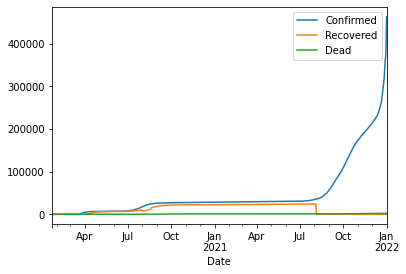

In [2]:
si_df = None
for col in ['Confirmed', 'Recovered', 'Dead']:
    
    # Read data and filter for Australia
    sidf = pd.read_csv(f'data/{col}.csv') 
    sidf = sidf[sidf['Country/Region'] == 'Australia']
    
    # Pivot dates
    print(col)
    print(sidf.columns[4:]) 
    print(sidf.columns[:4])
    id_cols = sidf.columns[:4]
    print()

    sidf = sidf.melt(id_vars = id_cols, var_name = 'Date', value_name = col)
    sidf = sidf[['Province/State', 'Date', col]] 
    
    # Aggregate to national level and set date index
    sidf = sidf.groupby('Date')[col].sum().reset_index() 
    sidf['Date'] = pd.to_datetime(sidf['Date'], format='%m/%d/%y')
    sidf = sidf.sort_values('Date').set_index('Date')
    
    # Add to output
    if si_df is None:
        si_df = sidf
    else:
        si_df = si_df.join(sidf)
    
# Check output
si_df.to_csv('check.csv')
si_df.plot()

### Read vaccination data

            Vaccinated
Date                  
2021-03-18         206
2021-03-19         340
2021-03-20         467
2021-03-21         467
2021-03-22         467


<AxesSubplot:xlabel='Date'>

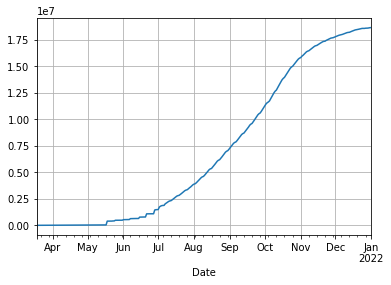

In [3]:
# Read data
vdf = pd.read_csv('data/v_ts.csv')

# Set datetime index
vdf['Date'] = pd.to_datetime(vdf['Date'], format="%d/%m/%Y")
vdf = vdf.sort_values(by='Date').set_index('Date') 

# Aggregate to national level
list_of_states = ['NSW','VIC','QLD','SA','WA','TAS','NT','ACT']
vdf['Vaccinated'] = vdf.loc[:,list_of_states].sum(axis=1)

# Check
vdf = vdf[['Vaccinated']] 

print(vdf.head()) 
vdf['Vaccinated'].plot(grid=True)  

### Join datasets to get input data for model

<AxesSubplot:xlabel='Date'>

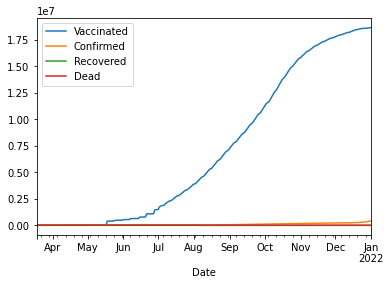

In [4]:
df_siv = vdf.join(si_df)
df_siv.plot()
#df_siv = df_siv['2021-05-01':'2021-08-04']
#df_siv.plot() 

## Fit model

      fun: 2108992.5946410727
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 15.92561612, -12.34002412,  -3.49245968,  12.38659032])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 20
      nit: 2
     njev: 4
   status: 0
  success: True
        x: array([1.00000013, 0.30000042, 4.4336736 , 2.42655205])


<AxesSubplot:xlabel='Date'>

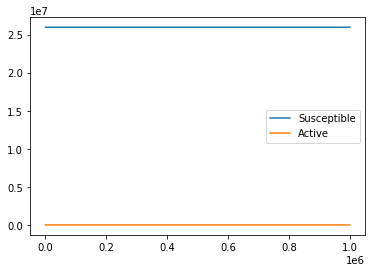

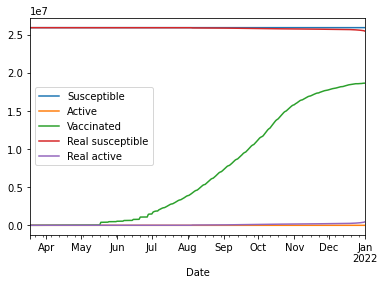

In [5]:
auspop = 25954112

vac=df_siv['Vaccinated'].values
active = df_siv['Confirmed'].values - df_siv['Recovered'].values
sus = auspop-active 

def get_vac(t):
    val = floor(t)
    last = len(vac)-1
    return vac[min(val, last)]

def simodel(y, t, p): 
    bu, bv, gu, gv = p 
    s, i = y 
    vt = get_vac(t) 
    flow = ((auspop-vt)/(auspop))*(-bu*s*i/auspop +gu*i) + (vt/(auspop))*(-bv*s*i/auspop +gv*i)  
    return [flow, -flow]

def fit_simodel(p, ynought, tvec):
    m_with_params = lambda y, t: simodel(y,t,p)
    return odeint(m_with_params, ynought, tvec)

tv = [x for x in range(len(vac))] 
y0 = [sus[0], active[0]] 

def f_resid(p):  
    fitted = fit_simodel(p, y0, tv)
    return np.linalg.norm(sus-fitted[:,0]) 

fitted = minimize(f_resid, 
                  [1,.3,1/25,1/25], 
                  method='L-BFGS-B',
                  bounds=((0,None), (0,None), (0,None), (0,None)))
print(fitted)

results = fit_simodel(fitted.x, y0, [x for x in range(1000000)])  
df = pd.DataFrame(results, columns = ['Susceptible', 'Active'])  
df[['Susceptible', 'Active']].plot()  

results = fit_simodel(fitted.x, y0, tv)
df = pd.DataFrame(results, columns = ['Susceptible', 'Active'])
df['Date'] = df_siv.index
df['Vaccinated'] = vac
df['Real susceptible'] = sus
df['Real active'] = active
df = df.set_index('Date')
df.plot() 

### Simplified model fit

      fun: 311293.72548483155
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 205.25767479, 5119.32885544])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 216
      nit: 15
     njev: 72
   status: 0
  success: True
        x: array([0.07949328, 0.06537922])

Fitting model

beta=0.07949328147706451, gamma=0.06537922094854555
steady state: 4605633.838808925 cases


Trying custom values

beta=0.1, gamma=0.07142857142857142
steady state: 7415460.567553406 cases



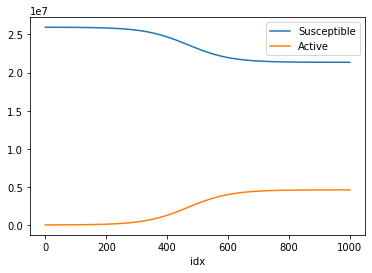

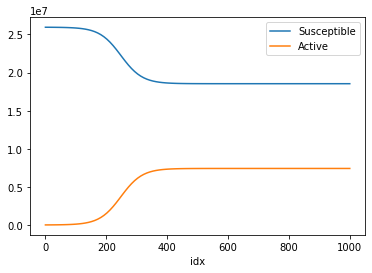

In [6]:
auspop = 25954112
 
active = df_siv['Confirmed'].values - df_siv['Recovered'].values
sus = auspop-active  

def simodel(y, t, p): 
    b, g = p 
    s, i = y 
    flow = -b*s*i/auspop +g*i 
    return [flow, -flow]

def fit_simodel(p, times, ynought):
    m_with_params = lambda y, t: simodel(y,t,p)
    return odeint(m_with_params, ynought, times)

tv = [x for x in range(len(active))] 
y0 = [sus[0], active[0]]

def f_resid(p):  
    fitted = fit_simodel(p, tv, y0)
    return np.linalg.norm(sus-fitted[:,0])

fitted = minimize(f_resid, [1,1/100], method='L-BFGS-B', bounds = ((0,None), (0, None)))
print(fitted) 

t_new = np.linspace(0,1000,100)

def plot_model(params):
    fitted_model = pd.DataFrame(fit_simodel(params, t_new, y0), columns = ['Susceptible','Active'])
    fitted_model['idx'] = t_new
    fitted_model = fitted_model.set_index('idx')
    fitted_model.plot()
    print(f'\nbeta={params[0]}, gamma={params[1]}')
    print(f'steady state: {max(fitted_model["Active"])} cases\n')

print('\nFitting model')
plot_model(fitted.x)
print('\nTrying custom values')
plot_model([.1,1/14])

# Discussion of Model 1
* Data was quite bad
    * Look at alternative data
    * Perhaps we can use location granularity somehow
    * Would it be easier to model a different country, or the original COVID outbreak (in 2020)?
* Model structure may have been off
    * Could look into reinfection rates and possibility of a SEIR model or something
        * Would need to get data to apply
        
        Vaccines protect against reinfection more than being previously infected, although in general reinfection is very possible
        
        
* Could look at just running simulations without having to fit to data

# Model 2 (Alternative data, SEIR model)